In [1]:
# %matplotlib notebook
%matplotlib inline
from ipynb_setup import *
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

import os
import re

In [2]:
from utils.file_utils import get_experiment_df, get_experiment_configs_df
from utils.path_utils import visuals_folder
from plotlib.performance_plots import plot_standard_dev

In [3]:
sns.set_style("whitegrid")

## Path Selection

In [4]:
base_paths = []

# CIFAR-10
# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar10/active-cifar10_low"))
base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar10/active-cifar10_med"))
# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar10/active-cifar10_high"))


# CIFAR-100
# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar100/active-standard"))
# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar100/active-cifar100"))

## Run Selection

In [19]:
match_patterns = [
    r"basic_.*",
    r"basic-pretrained_.*",
#     r"fixmatch_.*",
#     r"fixmatch-pretrained_.*",
]

filter_patterns = [
#     ".*wd-0.01_.*"
#     r".*kcenter.*",
#     r".*variationratios.*"
]

## Style and Color Selection

In [20]:
hue_name = "Acquisition"

hue_split = "acq-"

style_name = "PreTraining & Semi-Supervised"
style_fct = lambda x: "PT: {}, Sem-SL: {}".format(
    "pretrained_model" in x.name,
    "fixmatch" in x.name
)

unit_vals = None
unit_name = "Unit"

## Fetch Data

In [21]:
dfs = []

for base_path in base_paths:
    paths = [path for path in base_path.iterdir() if path.is_dir()]
    paths.sort()
    print("Folders in Path: \n {}\n".format(base_path))

    
    experiment_paths = []
    for path in paths:
#         print(path)
        for pattern in match_patterns:
#             print(path.name)
            out = re.match(pattern, str(path.name))
            if out is not None:
                print(path.name)
                skip = False
                for filter_pattern in filter_patterns:
                    if re.match(filter_pattern, str(path)) is not None:
                        skip=True
                if skip:
                    continue

                print(path.name)
                experiment_paths.append(path)
                continue
                    


    hue_names = [path.name.split(hue_split)[1].split('_')[0] for path in experiment_paths]#.split('_')[0] for path in paths]
    style_vals = [style_fct(path) for path in experiment_paths]


    df = []
    for i, (base_dir) in enumerate(experiment_paths):
        base_dir = Path(base_dir)
        if hue_names is not None:
            hue_val = hue_names[i]
        else:
            hue_val = None
        if style_vals is not None:
            style_val = style_vals[i]
        else:
            style_val = None
        if unit_vals is not None:
            unit_val = unit_vals[i]
        else:
            unit_val = None

        experiment_frame = get_experiment_df(base_dir, hue_val)
        # experiment_frame[hue_name] = hue_val
        if experiment_frame is None:
            continue
        experiment_frame[hue_name] = hue_val
        experiment_frame[style_name] = style_val
        experiment_frame[unit_name] = unit_val
        df.append(experiment_frame)
    df = pd.concat(df)
    df.reset_index(inplace=True)

    dfs.append(df)

Folders in Path: 
 /home/c817h/Documents/logs_cluster/activelearning/cifar10/active-cifar10_med

basic-pretrained_model-resnet_drop-0.5_aug-cifar_randaugment_acq-bald_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0.5_aug-cifar_randaugment_acq-bald_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-entropy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-entropy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-kcentergreedy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-kcentergreedy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-random_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-random_ep-80_freeze-False_smallhead-False
basic_model-resnet_drop-0.5_aug-cifar_randaugme

## Create Plot

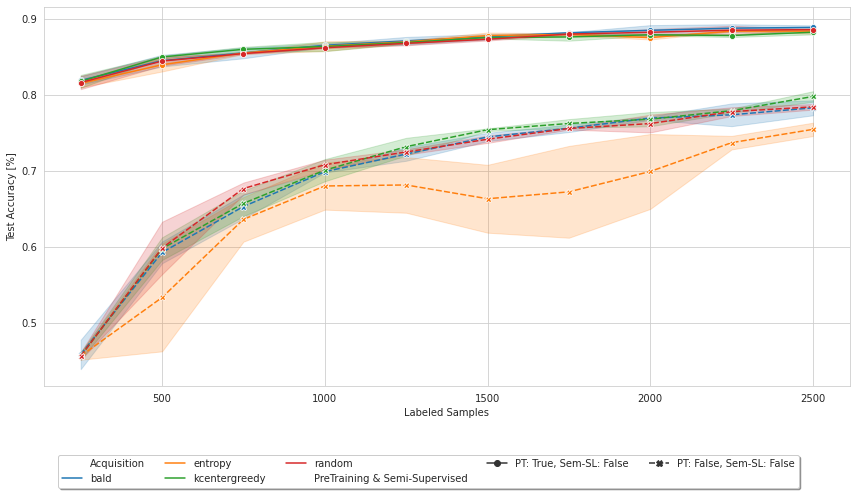

In [12]:
num_cols = len(dfs)
ax_legend = 0
fig, axs = plt.subplots(ncols=num_cols, sharey=True)
if num_cols == 1:
    axs = [axs]
if style_vals is None:
    style_name = None
if unit_vals is None:
    unit_name = None

for i in range(num_cols):
    df = dfs[i]
    ax = axs[i]
  
    legend = False
    if i == ax_legend:
        legend = 'auto'
    ax = plot_standard_dev(
        ax, df, hue=hue_name, style=style_name, units=unit_name, ci = 'sd', legend=legend
    )  # , units=unit_name)
    ax.set_xlabel("Labeled Samples")
    ax.set_ylabel("Test Accuracy [%]")
    if i == ax_legend:
        ax.get_legend().remove()
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()

## Obtain Numerical Results

In [53]:
metric = "test_acc"

In [54]:
df = dfs[0]
df_random = df[df["Name"]=="random"]
# df_random = df.loc[:, ["test_acc", "num_samples", "PreTraining & Semi-Supervised"]]

In [56]:
for i in range(len(dfs)):
    df = dfs[i]
    df_random = df[df["Name"]=="random"]
    df_random = df_random.groupby(["num_samples", "PreTraining & Semi-Supervised"], ).agg({metric : ['mean', 'std']}).round(4)*100
    print(base_paths[i])
    print(df_random)

/home/c817h/Documents/logs_cluster/activelearning/cifar10/active-cifar10_med
                                          test_acc      
                                              mean   std
num_samples PreTraining & Semi-Supervised               
250         PT: False, Sem-SL: False         45.61  0.48
            PT: True, Sem-SL: False          81.64  0.87
500         PT: False, Sem-SL: False         59.85  3.45
            PT: True, Sem-SL: False          84.47  0.61
750         PT: False, Sem-SL: False         67.67  0.79
            PT: True, Sem-SL: False          85.45  0.08
1000        PT: False, Sem-SL: False         70.81  0.67
            PT: True, Sem-SL: False          86.22  0.06
1250        PT: False, Sem-SL: False         72.49  0.35
            PT: True, Sem-SL: False          86.80  0.26
1500        PT: False, Sem-SL: False         74.17  0.48
            PT: True, Sem-SL: False          87.34  0.17
1750        PT: False, Sem-SL: False         75.59  0.15
           